
The total number of signals corresponds to RIGHT HAND MOVEMENT is 500000 while for RIGHT FOOT MOVEMENT it was 400000. 
Each class has 118 channels.
Initial sampling rate = 1KHz, i.e. 1000 samples are captured in one second.
The data is downsampled to 100 Hz,  i.e. 100 samples in one second.

In [1]:
# Importing required libraries required to execution
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # for data visualization
import seaborn as sns # for statistical data visualization
%matplotlib inline
import scipy.io
import warnings
warnings.filterwarnings('ignore') # ignoring warnings if any just to avoid confusion during the execution

### Load the data stored in .MAT file and assign respective classes

In [2]:
# Load the data which is stored in MAT file
BCI_data = scipy.io.loadmat('bci.mat')
RH = BCI_data['rh'] # Signals belonging to right hand (RH) movement
RF = BCI_data['rf'] # Signals belonging to right foot (RF) movement
# Display the keys and structure of the BCI_data dictionary
print("Keys in BCI_data:", BCI_data.keys())
print("Structure of BCI_data:", BCI_data['rh'].shape, BCI_data['rf'].shape)

Keys in BCI_data: dict_keys(['__header__', '__version__', '__globals__', 'rf', 'rh'])
Structure of BCI_data: (400000, 118) (500000, 118)


In [3]:
# Find NaN values in matrix2
nan_mask = np.isnan(RH)  # Boolean mask where NaNs are present

# Get row and column indices of NaNs
nan_positions = np.argwhere(nan_mask)  # Returns list of (row, col) positions

# Find which columns contain NaNs
nan_columns = np.where(np.any(nan_mask, axis=0))[0]  # Columns with NaN values

# Print results
# Print results
print(f"NaN values found in {len(nan_positions)} locations.")
print(f"Columns with NaN values: {nan_columns.tolist()}")
print(f"First 10 NaN positions (row, col): {nan_positions[:10].tolist()}")  # Show first 10 for brevity

NaN values found in 0 locations.
Columns with NaN values: []
First 10 NaN positions (row, col): []


In [4]:
# Function to impute NaN values with column mean (for median imputation just replace nanmedian)
def impute_with_mean(matrix):
    # Find NaN values
    nan_mask = np.isnan(matrix)
    
    # Calculate column means (ignoring NaNs)
    col_means = np.nanmedian(matrix, axis=0)
    
    # Replace NaNs with corresponding column mean
    matrix[nan_mask] = np.take(col_means, np.where(nan_mask)[1])
    
    return matrix

# Impute NaN values in both matrix1 and matrix2
RH = impute_with_mean(RH)
RF = impute_with_mean(RF)


### Verify if there are nan values

In [5]:
# Find NaN values in matrix2
nan_mask = np.isnan(RF)  # Boolean mask where NaNs are present

# Get row and column indices of NaNs
nan_positions = np.argwhere(nan_mask)  # Returns list of (row, col) positions

# Find which columns contain NaNs
nan_columns = np.where(np.any(nan_mask, axis=0))[0]  # Columns with NaN values

# Print results
# Print results
print(f"NaN values found in {len(nan_positions)} locations.")
print(f"Columns with NaN values: {nan_columns.tolist()}")
print(f"First 10 NaN positions (row, col): {nan_positions[:10].tolist()}")  # Show first 10 for brevity

NaN values found in 0 locations.
Columns with NaN values: []
First 10 NaN positions (row, col): []


In [6]:
# from scipy.stats import mode

### Code for mode-based imputation
# def impute_with_mode(matrix):
#     # Find NaN values
#     nan_mask = np.isnan(matrix)

#     # Calculate column mode (ignoring NaNs) most frequent value in the column
#     col_modes = np.array([mode(matrix[:, i], nan_policy='omit').mode[0] for i in range(matrix.shape[1])])

#     # Replace NaNs with corresponding column mode
#     matrix[nan_mask] = np.take(col_modes, np.where(nan_mask)[1])

#     return matrix

# Usage
# RH = impute_with_mode(RH)
# RF = impute_with_mode(RF)

In [7]:
from scipy.signal import butter, filtfilt, iirnotch

def bandpass_filter(data, lowcut, highcut, fs, order=7):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    y = filtfilt(b, a, data)
    return y

def notch_filter(data, notch_freq, fs, quality_factor=20):
    nyquist = 0.5 * fs
    notch = notch_freq / nyquist
    b, a = iirnotch(notch, quality_factor)
    y = filtfilt(b, a, data)
    return y

fs = 100  # sampling frequency in Hz
# Apply notch filter to suppress 50 Hz signal
filtered_RF = notch_filter(RF, 50, fs)
filtered_RH = notch_filter(RH, 50, fs)

# Apply bandpass filter between 0.5-30 Hz
filtered_signal_RF = bandpass_filter(filtered_RF, 0.5, 30, fs)
filtered_signal_RH = bandpass_filter(filtered_RH, 0.5, 30, fs)



In [8]:
# Reshape the data and only select any one channel for simplicity
Right_hand = filtered_signal_RH[:,0:2] # Select any one channel but not the channel should be same for RH and RF
Right_foot = filtered_signal_RF[:,0:2] # Select any one channel but not the channel should be same for RH and RF
#20 channels
Right_hand = Right_hand.reshape(400*2, 1000) # Reshape the right hand data of second channel into 20 second (100 Hz *10 sec)
Right_foot = Right_foot.reshape(500*2, 1000) # Reshape the right foot data of second channel into 20 second (100 Hz *10 sec)

### Now create a binary labels indicating RH and RF

In [9]:
Y = np.concatenate((np.zeros((400*2,1)), np.ones((500 *2,1))), axis=0) 
X = np.concatenate((Right_hand,Right_foot)) # 0 indicate RH and 1 indicate RF

## This section indicate feature extraction 

#### Statistical Features

In [10]:
import scipy.stats as stats

In [11]:
# Statistical Features
def extract_statistical_features(signal):
    mean = np.mean(signal)
    median = np.median(signal)
    std_dev = np.std(signal)
    variance = np.var(signal)
    skewness = stats.skew(signal)
    kurtosis = stats.kurtosis(signal)
    range_val = np.ptp(signal)
    
    features = {
        'Mean': mean,
        'Median': median,
        'Standard Deviation': std_dev,
        'Variance': variance,
        'Skewness': skewness,
        'Kurtosis': kurtosis,
        'Range': range_val
    }
    
    return features

stat_features = [extract_statistical_features(signal) for signal in X]
# print(stat_features[0])

#### Time Domain Features

In [12]:
# Time Domain Features
def extract_time_domain_features(signal):
    rms = np.sqrt(np.mean(signal**2))
    zero_crossings = ((signal[:-1] * signal[1:]) < 0).sum()
    autocorrelation = np.correlate(signal, signal, mode='full')[len(signal)-1]
    mean_abs_dev = np.mean(np.abs(signal - np.mean(signal)))
    max_val = np.max(signal)
    min_val = np.min(signal)
    signal_energy = np.sum(signal**2)
    
    features = {
        'RMS': rms,
        'Zero Crossings': zero_crossings,
        'Autocorrelation': autocorrelation,
        'Mean Absolute Deviation': mean_abs_dev,
        'Max Value': max_val,
        'Min Value': min_val,
        'Signal Energy': signal_energy
    }
    
    return features

time_features = [extract_time_domain_features(signal) for signal in X]

#### Frequency Domain Features

In [13]:
# Frequency Domain Features
import numpy as np
from scipy.signal import welch
def extract_frequency_domain_features(signal):
    fs = 100
    freqs, psd = welch(signal, fs)
    dominant_freq = freqs[np.argmax(psd)]
    total_power = np.sum(psd)
    band_power = np.sum(psd[(freqs >= 0.5) & (freqs <= 40)])
    mean_freq = np.mean(freqs)
    median_freq = np.median(freqs)
    peak_freq = freqs[np.argmax(psd)]
    freq_variance = np.var(freqs)
    
    features = {
        'Dominant Frequency': dominant_freq,
        'Total Power': total_power,
        'Band Power (0.5-40 Hz)': band_power,
        'Mean Frequency': mean_freq,
        'Median Frequency': median_freq,
        'Peak Frequency': peak_freq,
        'Frequency Variance': freq_variance
    }
    
    return features

freq_features = [extract_frequency_domain_features(signal) for signal in X] # fs is a sampling rate

In [14]:
import pywt
import antropy as ant

#### Entropy Features

In [15]:
# Entropy Features
def extract_entropy_features(signal):
    fs = 100
    sample_entropy = ant.sample_entropy(signal)
    spectral_entropy = ant.spectral_entropy(signal, sf=fs, method='welch')
    perm_entropy = ant.perm_entropy(signal, normalize=True)
    svd_entropy = ant.svd_entropy(signal, order=3, delay=1)
    app_entropy = ant.app_entropy(signal)
    lziv_complexity = ant.lziv_complexity(signal)
    
    # Create a dictionary of entropy features
    features = {
        'Sample Entropy': sample_entropy,  # Measure of complexity, higher values indicate more complexity
        'Spectral Entropy': spectral_entropy,  # Measure of the power distribution in the frequency domain
        'Permutation Entropy': perm_entropy,  # Measure of the complexity of the time series
        'SVD Entropy': svd_entropy,  # Measure of the complexity using Singular Value Decomposition
        'Approximate Entropy': app_entropy,  # Measure of the regularity and unpredictability of fluctuations
        'LZiv Complexity': lziv_complexity  # Measure of the complexity of the sequence
    }
    
    return features

entropy_features = [extract_entropy_features(signal) for signal in X] # fs is a sampling rate


### Feature concatenation 

In [16]:
# Combine all features into a single DataFrame
def combine_features(stat_features, time_features, freq_feature, entropy_features):
    combined_features_list = []
    for i in range(len(stat_features)):
        combined_features = {**stat_features[i], **time_features[i], **freq_features[i], **entropy_features[i], }
        combined_features_list.append(combined_features)
    return pd.DataFrame(combined_features_list)

combined_features_df = combine_features(stat_features, time_features, freq_features, entropy_features)
print("Combined Features DataFrame:")
print(combined_features_df)

Combined Features DataFrame:
           Mean     Median  Standard Deviation      Variance  Skewness  \
0    -58.336908 -31.122494          133.158459  17731.175224 -1.455073   
1    -30.611620 -36.969093          104.925841  11009.432094  0.123653   
2    -46.353556 -15.151991          146.849198  21564.687012 -0.350834   
3     -4.002077  -4.979180          191.404985  36635.868116  0.019955   
4    -20.853292  -9.338214          239.040137  57140.187024 -0.134457   
...         ...        ...                 ...           ...       ...   
1795 -20.360734 -27.439854           35.783745   1280.476380  0.049482   
1796  -9.305134 -17.417124           26.667106    711.134564 -0.417993   
1797 -17.853859 -13.294949           28.307026    801.287698 -0.552226   
1798 -24.393454  -9.362261           26.848555    720.844887 -0.510492   
1799  -8.631553  -7.156409           17.904378    320.566740 -0.209472   

      Kurtosis        Range         RMS  Zero Crossings  Autocorrelation  ...  \
0

In [17]:
from sklearn.preprocessing import StandardScaler
# Create DataFrame
df = pd.DataFrame(combined_features_df)

# Initialize the StandardScaler
scaler = StandardScaler()

# Apply the scaler to normalize the data
normalized_data = scaler.fit_transform(df)

# Convert the result back into a DataFrame
normalized_df = pd.DataFrame(normalized_data, columns=combined_features_df.columns)
print(normalized_df)

          Mean    Median  Standard Deviation  Variance  Skewness  Kurtosis  \
0    -0.621475 -0.190889            1.380690  0.783104 -2.412486  4.346887   
1     0.150556 -0.395169            0.856554  0.320300  0.960940  0.523938   
2    -0.287790  0.367120            1.634858  1.047049 -0.052945  0.903640   
3     0.891519  0.722558            2.462032  2.084727  0.739360  0.150434   
4     0.422285  0.570254            3.346375  3.496487  0.409411  0.070918   
...        ...       ...                 ...       ...       ...       ...   
1795  0.436000 -0.062217           -0.427063 -0.349557  0.802452 -0.050238   
1796  0.743852  0.287977           -0.596313 -0.388757 -0.196450  0.378168   
1797  0.505806  0.432005           -0.565868 -0.382550 -0.483279  0.227093   
1798  0.323706  0.569413           -0.592945 -0.388088 -0.394101 -0.032878   
1799  0.762608  0.646486           -0.758992 -0.415648  0.249118  0.009174   

         Range       RMS  Zero Crossings  Autocorrelation  ... 

### Feature selection

In [18]:
# Import necessary libraries
from sklearn.decomposition import PCA
import seaborn as sns

In [19]:

# # Scree plot to visualize explained variance ratio
# explained_variance_ratio = PCA(n_components=len(normalized_df.columns)).fit(normalized_df).explained_variance_ratio_
# plt.figure(figsize=(8, 6))
# plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o')
# plt.title('Scree Plot')
# plt.xlabel('Principal Component')
# plt.ylabel('Explained Variance Ratio')
# plt.xticks(range(1, len(explained_variance_ratio) + 1), rotation=90)
# plt.grid(True)
# plt.savefig('scree_plot')
# plt.show()




# Pareto plot

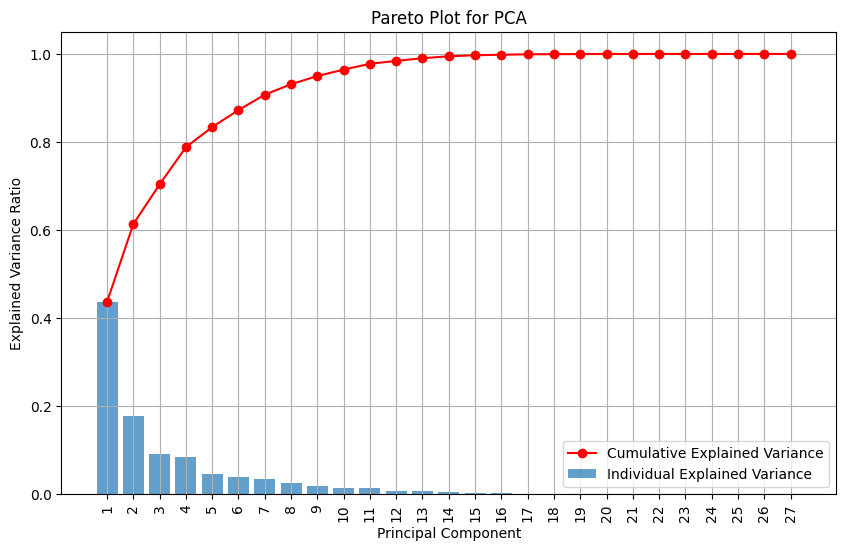

Pareto plot saved as 'pareto_plot_pca'


In [20]:
# Pareto plot for PCA
explained_variance_ratio = PCA(n_components=len(normalized_df.columns)).fit(normalized_df).explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.7, label='Individual Explained Variance')
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='o', color='r', label='Cumulative Explained Variance')
plt.title('Pareto Plot for PCA')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.xticks(range(1, len(explained_variance_ratio) + 1), rotation=90)
plt.legend(loc='best')
plt.grid(True)
plt.savefig('pareto_plot_pca')
plt.show()
print("Pareto plot saved as 'pareto_plot_pca'")

In [21]:
threshold = 0.75  # Set your desired threshold 
num_components = np.argmax(cumulative_variance_ratio >= threshold) + 1
print(f"Number of components to select: {num_components}")

Number of components to select: 4


# PCA

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=num_components)
pca_result = pca.fit_transform(normalized_data)
print("Explained Variance Ratio:", pca.explained_variance_ratio_)
print("Sum of Explained Variance Ratio:", np.sum(pca.explained_variance_ratio_))

Explained Variance Ratio: [0.43630254 0.1771657  0.09003946 0.08462811]
Sum of Explained Variance Ratio: 0.7881358079473526


### Classification using SVM (linear and nonlinear)

In [23]:
# Import SVM and train test split
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

In [24]:
X_train, X_test, y_train, y_test = train_test_split(pca_result, Y, test_size=0.2, random_state=42)
# Suing 70% data for trainig and 30% data for testing
X_train_2d = X_train
X_test_2d = X_test

In [48]:
# def plot_decision_boundary(clf, X, y, name):
#     # Convert X to NumPy array if it's a DataFrame
#     if hasattr(X, "values"):
#         X = X.values

#     # Create a mesh grid
#     x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
#     y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
#     xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
#                          np.linspace(y_min, y_max, 500))

#     # Predict on grid points
#     Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
#     Z = Z.reshape(xx.shape)

#     # Plot contours
#     plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), Z.max(), 50), cmap=plt.cm.coolwarm, alpha=0.8)
#     plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='k')  # Decision boundary

#     # Scatter plot of data points
#     plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolors='k')
#     plt.xlabel('Feature 1')
#     plt.ylabel('Feature 2')
#     plt.title(name)
#     plt.show()

# Linear SVM

In [26]:
# # Initialize linear and nonlinear SVM models
# linear_svm = SVC(kernel='linear',C=1, probability=True)  # You can change kernel to 'rbf', 'poly', etc.
# # Train the SVM model on the reduced dataset
# linear_svm = SVC(kernel='linear')
# linear_svm.fit(X_train_2d, y_train)
# # Evaluate the models
# linear_score = linear_svm.score(X_test_2d, y_test)
# print("Linear SVM Accuracy:", linear_score)

# plot_decision_boundary(linear_svm, X_train, y_train,'SVM_Linear')

# Non linear svm

In [27]:
# nonlinear_svm = SVC(kernel='rbf',C=2, gamma=1,  probability=True)  # You can change kernel to 'rbf', 'poly', etc.
# nonlinear_svm.fit(X_train_2d, y_train)
# nonlinear_score = nonlinear_svm.score(X_test_2d, y_test)
# print("Nonlinear SVM Accuracy:", nonlinear_score)


In [28]:
# plot_decision_boundary(nonlinear_svm, X_train, y_train,'SVM_Non_Linear')

### Plot Confusion Matrix for linear and non linear SVM

In [29]:
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# # Plot confusion matrices for both models
# y_pred_linear = linear_svm.predict(X_test_2d)
# y_pred_nonlinear = nonlinear_svm.predict(X_test_2d)

# cm_linear = confusion_matrix(y_test, y_pred_linear)
# cm_nonlinear = confusion_matrix(y_test, y_pred_nonlinear)

# disp_linear = ConfusionMatrixDisplay(confusion_matrix=cm_linear,
#                                      display_labels=['Right hand', 'Right foot'])
# disp_nonlinear = ConfusionMatrixDisplay(confusion_matrix=cm_nonlinear,
#                                         display_labels=['Right hand', 'Right foot'])

# disp_linear.plot(cmap=plt.cm.Blues)
# plt.title("Confusion Matrix - Linear SVM")
# plt.savefig("CM_L_SVM")
# plt.show()

# disp_nonlinear.plot(cmap=plt.cm.Blues)
# plt.title("Confusion Matrix - Nonlinear SVM")
# plt.savefig("CM_NL_SVM")
# plt.show()



### Classification Report

In [30]:
# from sklearn.metrics import classification_report
# report_linear = classification_report(y_test, y_pred_linear, target_names=['Right hand', 'Right foot'])
# report_nonlinear = classification_report(y_test, y_pred_nonlinear, target_names=['Right hand', 'Right foot'])
# print("Classification Report for Linear SVM:")
# print(report_linear)
# print(" Classification Report for Nonlinear SVM:")
# print(report_nonlinear)

### ROC AUC Curve

In [31]:
# from sklearn.metrics import roc_curve, auc

# # Compute ROC curve and ROC area
# fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred_nonlinear)
# roc_auc = auc(fpr, tpr)

# # Plot ROC curve with detailed annotations

# plt.figure(figsize=(10, 7))
# plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic (ROC) Curve')
# plt.legend(loc="lower right")
# plt.grid(True)



In [32]:
# from sklearn.metrics import roc_curve, auc

# # Compute ROC curve and ROC area
# fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred_linear)
# roc_auc = auc(fpr, tpr)

# # Plot ROC curve with detailed annotations

# plt.figure(figsize=(10, 7))
# plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic (ROC) Curve')
# plt.legend(loc="lower right")
# plt.grid(True)



### Training with Entire data

### Validation using 10-fold cross validation

In [33]:
# from sklearn.model_selection import cross_val_score, KFold
# from sklearn.svm import SVC
# # Define SVM classifier
# svm_model = SVC(kernel='rbf',C=0.3, gamma=0.3,  probability=True)  # You can change kernel to 'rbf', 'poly', etc.

# # Define 10-fold cross-validation
# kf = KFold(n_splits=10, shuffle=True, random_state=42)

# # Create a plot for ROC
# plt.figure(figsize=(12, 8))

# # Initialize a matrix to store the combined confusion matrix
# combined_confusion_matrix = np.zeros((len(np.unique(Y)), len(np.unique(Y))), dtype=int)

# # Initialize lists to store all true labels and predicted probabilities
# y_true_combined = []
# y_pred_prob_combined = []


# # Perform cross-validation manually to access each fold
# for fold, (train_index, test_index) in enumerate(kf.split(normalized_data), start=1):
#     X_train, X_test = normalized_data[train_index], normalized_data[test_index]
#     y_train, y_test = Y[train_index], Y[test_index]
    
#     # Train the model
#     svm_model.fit(X_train, y_train)
    
#     # Get probability predictions for ROC curve
#     y_prob = svm_model.predict_proba(X_test)
    
#     # Append true labels and predicted probabilities to combined lists
#     y_true_combined.extend(y_test)
#     y_pred_prob_combined.extend(y_prob)
    
#     # Calculate confusion matrix for this fold
#     cm = confusion_matrix(y_test, svm_model.predict(X_test))
    
#     # Combine confusion matrix (sum them)
#     combined_confusion_matrix += cm
    
#     # Print confusion matrix for this fold
#     print(f'Confusion Matrix for Fold {fold}:\n{cm}')
#     print('-' * 50)

# # Print the combined confusion matrix
# print(f'Combined Confusion Matrix across all folds:\n{combined_confusion_matrix}')

### Grid Search for best parameter selection

# grid search for SVM

Best Parameters: {'C': 1, 'gamma': 1, 'kernel': 'rbf'}
Best Cross-Validation Accuracy: 0.9479166666666666
Test Accuracy: 0.9611111111111111


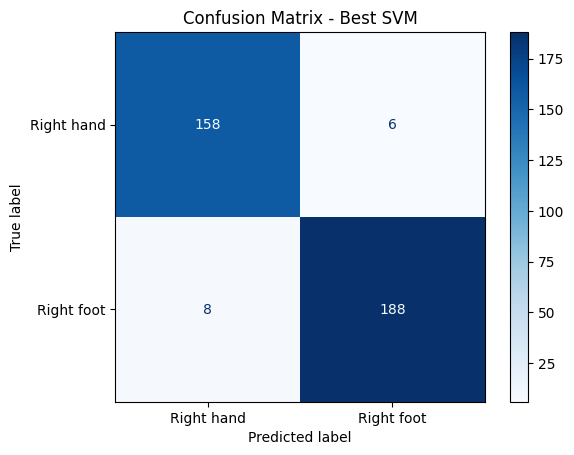

Classification Report for Best SVM:
              precision    recall  f1-score   support

  Right hand       0.95      0.96      0.96       164
  Right foot       0.97      0.96      0.96       196

    accuracy                           0.96       360
   macro avg       0.96      0.96      0.96       360
weighted avg       0.96      0.96      0.96       360



In [34]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
# Define the SVM model
svm = SVC()

# Define the grid of hyperparameters to search
param_grid = {
    'C': [0.1, 1, 10, 100],  # Regularization parameter
    'gamma': [0.001, 0.01, 0.1, 1],  # Kernel coefficient
    'kernel': ['linear', 'rbf', 'poly']  # Kernel type
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(svm, param_grid, cv=10, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

# Train the best model on the full training set
best_svm = grid_search.best_estimator_
y_pred = best_svm.predict(X_test)

# Evaluate the final model
print("Test Accuracy:", accuracy_score(y_test, y_pred))
# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Right hand', 'Right foot'])

# Plot confusion matrix
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Best SVM")
plt.show()

# Generate classification report
report = classification_report(y_test, y_pred, target_names=['Right hand', 'Right foot'])
print("Classification Report for Best SVM:")
print(report)
# Plot decision boundary for the best SVM model
# plot_decision_boundary(best_svm, X_train, y_train.ravel(), 'Decision Boundary - Best SVM')

# grid search for random forest

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters for Random Forest: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Best Cross-Validation Accuracy for Random Forest: 0.945138888888889
Test Accuracy for Random Forest: 0.9527777777777777


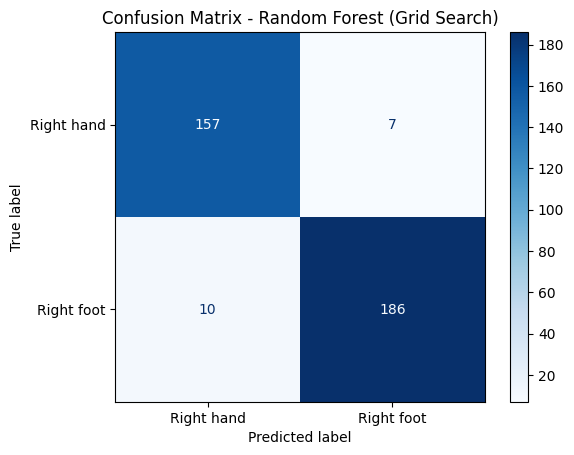

Classification Report for Random Forest (Grid Search):
              precision    recall  f1-score   support

  Right hand       0.94      0.96      0.95       164
  Right foot       0.96      0.95      0.96       196

    accuracy                           0.95       360
   macro avg       0.95      0.95      0.95       360
weighted avg       0.95      0.95      0.95       360



In [35]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# Define the Random Forest model
rf = RandomForestClassifier(random_state=42)

# Define the grid of hyperparameters to search
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]  # Minimum number of samples required to be at a leaf node
}

# Perform grid search with cross-validation
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search_rf.fit(X_train, y_train.ravel())

# Print the best parameters and best score
print("Best Parameters for Random Forest:", grid_search_rf.best_params_)
print("Best Cross-Validation Accuracy for Random Forest:", grid_search_rf.best_score_)

# Train the best model on the full training set
best_rf = grid_search_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test)

# Evaluate the final model
rf_accuracy = accuracy_score(y_test, y_pred_rf)
print("Test Accuracy for Random Forest:", rf_accuracy)
# Generate confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=['Right hand', 'Right foot'])

# Plot confusion matrix
disp_rf.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Random Forest (Grid Search)")
plt.show()

# Generate classification report
report_rf = classification_report(y_test, y_pred_rf, target_names=['Right hand', 'Right foot'])
print("Classification Report for Random Forest (Grid Search):")
print(report_rf)

# grid search for KNN


Best Parameters for KNN: {'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'distance'}
Best Cross-Validation Accuracy for KNN: 0.9444444444444444
Test Accuracy for KNN: 0.9611111111111111


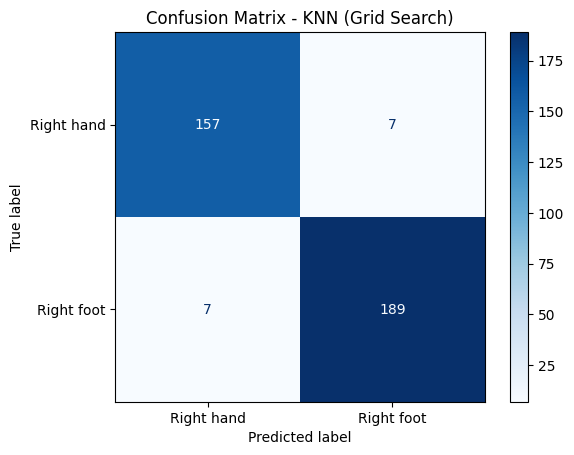

Classification Report for KNN (Grid Search):
              precision    recall  f1-score   support

  Right hand       0.96      0.96      0.96       164
  Right foot       0.96      0.96      0.96       196

    accuracy                           0.96       360
   macro avg       0.96      0.96      0.96       360
weighted avg       0.96      0.96      0.96       360



In [36]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Define the KNN model
knn = KNeighborsClassifier()

# Define the grid of hyperparameters to search
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],  # Number of neighbors
    'weights': ['uniform', 'distance'],  # Weight function
    'metric': ['euclidean', 'manhattan', 'minkowski']  # Distance metric
}

# Perform grid search with cross-validation
grid_search_knn = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy')
grid_search_knn.fit(X_train, y_train.ravel())

# Print the best parameters and best score
print("Best Parameters for KNN:", grid_search_knn.best_params_)
print("Best Cross-Validation Accuracy for KNN:", grid_search_knn.best_score_)

# Train the best model on the full training set
best_knn = grid_search_knn.best_estimator_
y_pred_knn = best_knn.predict(X_test)

# Evaluate the final model
knn_accuracy = accuracy_score(y_test, y_pred_knn)
print("Test Accuracy for KNN:", knn_accuracy)
# Generate the confusion matrix
cm_knn = confusion_matrix(y_test, y_pred_knn)

# Display the confusion matrix
disp_knn = ConfusionMatrixDisplay(confusion_matrix=cm_knn, display_labels=['Right hand', 'Right foot'])
disp_knn.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - KNN (Grid Search)")
plt.show()
# Generate classification report
report_knn = classification_report(y_test, y_pred_knn, target_names=['Right hand', 'Right foot'])
print("Classification Report for KNN (Grid Search):")
print(report_knn)

### Random forest

In [37]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# # Initialize the Random Forest model
# rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# # Train the model
# rf_model.fit(X_train, y_train.ravel())

# # Make predictions
# y_pred_rf = rf_model.predict(X_test)

# # Evaluate the model
# rf_accuracy = accuracy_score(y_test, y_pred_rf)
# print("Random Forest Accuracy:", rf_accuracy)

# # Print classification report
# rf_classification_report = classification_report(y_test, y_pred_rf, target_names=['Right hand', 'Right foot'])
# print(rf_classification_report)

# # Plot confusion matrix
# rf_cm = confusion_matrix(y_test, y_pred_rf)
# rf_disp = ConfusionMatrixDisplay(confusion_matrix=rf_cm, display_labels=['Right hand', 'Right foot'])
# rf_disp.plot(cmap=plt.cm.Blues)
# plt.title("Confusion Matrix - Random Forest")
# plt.savefig("CM_RF")
# plt.show()

# # # n method, so we use predict_proba instead
# # def plot_decision_boundary_proba(clf, X, y, name):
# #     print("shape",X.shape)
# #     # Convert X to NumPy array if it's a DataFrame
# #     if hasattr(X, "values"):
# #         X = X.values
        

# #     # Create a mesh grid
# #     x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
# #     y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
# #     xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
# #                          np.linspace(y_min, y_max, 500))

# #     # Predict probabilities on grid points
# #     Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
# #     Z = Z.reshape(xx.shape)

# #     # Plot contours
# #     plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), Z.max(), 50), cmap=plt.cm.coolwarm, alpha=0.8)
# #     plt.contour(xx, yy, Z, levels=[0.5], linewidths=2, colors='k')  # Decision boundary

# #     # Scatter plot of data points
# #     plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolors='k')
# #     plt.xlabel('Feature 1')
# #     plt.ylabel('Feature 2')
# #     plt.title(name)
# #     plt.savefig(name)
# #     plt.show()

# # plot_decision_boundary_proba(rf_model, X_train, y_train, 'RF')



In [38]:
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.metrics import accuracy_score
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# # Initialize the KNN model
# knn = KNeighborsClassifier(n_neighbors=5)  # You can adjust the number of neighbors

# # Train the model on the PCA result
# knn.fit(X_train, y_train.ravel())

# # Predict on the test set
# y_pred_knn = knn.predict(X_test)

# # Evaluate the model
# knn_accuracy = accuracy_score(y_test, y_pred_knn)
# print("KNN Accuracy:", knn_accuracy)

# # Plot the decision boundary for KNN
# def plot_knn_decision_boundary(clf, X, y, name):
#     # Convert X to NumPy array if it's a DataFrame
#     if hasattr(X, "values"):
#         X = X.values

#     # Create a mesh grid
#     x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
#     y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
#     xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
#                          np.linspace(y_min, y_max, 500))

#     # Predict on grid points
#     Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
#     Z = Z.reshape(xx.shape)

#     # Plot contours
#     plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.coolwarm)

#     # Scatter plot of data points
#     plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolors='k')
#     plt.xlabel('Feature 1')
#     plt.ylabel('Feature 2')
#     plt.title(name)
#     plt.show()

# # Generate and display the confusion matrix for KNN

# cm_knn = confusion_matrix(y_test, y_pred_knn)
# disp_knn = ConfusionMatrixDisplay(confusion_matrix=cm_knn, display_labels=['Right hand', 'Right foot'])

# disp_knn.plot(cmap=plt.cm.Blues)
# plt.title("Confusion Matrix - KNN")
# plt.show()

# # Plot the decision boundary for KNN
# plot_knn_decision_boundary(knn, X_train, y_train, 'KNN Decision Boundary')



In [39]:
# from sklearn.naive_bayes import GaussianNB
# from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# # Initialize the Naive Bayes model
# nb_model = GaussianNB()

# # Train the model on the PCA result
# nb_model.fit(X_train_2d, y_train.ravel())

# # Predict on the test set
# y_pred_nb = nb_model.predict(X_test_2d)

# # Evaluate the model
# nb_accuracy = accuracy_score(y_test, y_pred_nb)
# print("Naive Bayes Accuracy:", nb_accuracy)

# # Print classification report
# nb_classification_report = classification_report(y_test, y_pred_nb, target_names=['Right hand', 'Right foot'])
# print(nb_classification_report)

# # Plot confusion matrix
# nb_cm = confusion_matrix(y_test, y_pred_nb)
# nb_disp = ConfusionMatrixDisplay(confusion_matrix=nb_cm, display_labels=['Right hand', 'Right foot'])
# nb_disp.plot(cmap=plt.cm.Blues)
# plt.title("Confusion Matrix - Naive Bayes")
# plt.show()